In [121]:
import sqlite3
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling as pp
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [98]:
init_notebook_mode(connected=True)
cf.go_offline()

In [99]:
conn =sqlite3.connect("""database.sqlite""")
c = conn.cursor()

In [100]:
!pwd

/Users/flatiron/Desktop/Moussa/data_sc_fs


In [8]:
sql_1 = """

SELECT * FROM sqlite_master WHERE type="table" 

"""
c.execute(sql_1)
df_master = pd.DataFrame(c.fetchall())
df_master.columns = [x[0] for x in c.description]
df_master

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,1023,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Matches,Matches,810,"CREATE TABLE ""Matches"" (\n\t`Match_ID`\tINTEGE..."
2,table,Teams_in_Matches,Teams_in_Matches,4,CREATE TABLE Teams_in_Matches(\n Match_ID INT...
3,table,Teams,Teams,5,"CREATE TABLE ""Teams"" (\n\t`Season`\tTEXT,\n\t`..."
4,table,Unique_Teams,Unique_Teams,7,"CREATE TABLE ""Unique_Teams"" (\n\t`TeamName`\tT..."


In [9]:

df_teams = pd.DataFrame(c.execute( """

SELECT * FROM Teams 
WHERE season=2011

""").fetchall())

In [10]:
df_teams.columns = ['Season','TeamName','KaderHome','AvgAgeHome','ForeignPlayersHome'
                  ,'OverallMarketValueHome','AvgMarketValueHome','StadiumCapacity']

In [11]:
Team_Names = df_teams['TeamName'].unique() 

In [12]:
df_teams.head()

,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2011,Bayern Munich,24,25,11,335600000,13980000,75000
1,2011,Dortmund,28,24,12,158200000,5650000,81359
2,2011,Leverkusen,29,23,9,151100000,5210000,30210
3,2011,Schalke 04,37,24,20,136730000,3700000,62271
4,2011,Werder Bremen,38,23,17,125350000,3300000,42100


In [1]:
#pp.ProfileReport(df_teams)

# The name of the Teams

In [14]:
print(Team_Names)

['Bayern Munich' 'Dortmund' 'Leverkusen' 'Schalke 04' 'Werder Bremen'
 'Wolfsburg' 'Hamburg' 'Stuttgart' 'Hoffenheim' 'FC Koln' 'Hannover'
 "M'gladbach" 'Freiburg' 'Mainz' 'Hertha' 'Kaiserslautern' 'Nurnberg'
 'Augsburg' 'Ein Frankfurt' 'St Pauli' 'Cottbus' 'Bochum'
 'Fortuna Dusseldorf' 'Greuther Furth' 'Munich 1860' 'Aachen' 'Ingolstadt'
 'Duisburg' 'Karlsruhe' 'Dresden' 'Frankfurt FSV' 'Erzgebirge Aue'
 'Hansa Rostock' 'Union Berlin' 'Paderborn' 'Braunschweig']


In [15]:
df_matches = pd.DataFrame(c.execute( """

SELECT * FROM Matches 
where season = 2011

""").fetchall())

In [16]:
df_matches.columns = ['Match_ID','Div','Season','Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']

In [41]:
df_matches.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [18]:
df_team_gols=pd.DataFrame(c.execute("""
SELECT HomeTeam, Home_Goal,Away_Goal FROM (SELECT HomeTeam, SUM(FTHG) as Home_Goal from Matches WHERE Season = '2011' GROUP BY HomeTeam)
LEFT JOIN
(SELECT AwayTeam,SUM(FTAG) as Away_Goal from Matches WHERE Season = '2011' GROUP BY AwayTeam) ON HomeTeam = AwayTeam
GROUP BY HomeTeam
""").fetchall())


In [19]:
df_team_gols[1] = df_team_gols[1]+df_team_gols[2]

In [20]:
df_team_gols.columns = ['TeamName', 'TotalGols', 'Away']

In [21]:
df_team_gols.drop('Away', axis=1, inplace=True)

In [22]:
df_team_gols.head()

,TeamName,TotalGols
0,Aachen,30
1,Arsenal,74
2,Aston Villa,37
3,Augsburg,36
4,Bayern Munich,77


## Taotal Wins

In [23]:
df_Team_Wins = pd.DataFrame(c.execute("""
SELECT AwayTeam, COALESCE(FTRH,0) + COALESCE(FTRA,0) FROM
((SELECT AwayTeam, COUNT(FTR) AS FTRA FROM Matches WHERE FTR = 'A' AND Season = '2011' GROUP By AwayTeam)
LEFT JOIN
(SELECT HomeTeam, COUNT(FTR) AS FTRH FROM Matches WHERE FTR = 'H' AND Season = '2011' GROUP By HomeTeam)
ON AwayTeam = HomeTeam) GROUP BY AwayTeam
""").fetchall())
df_Team_Wins.columns = ["TeamName","Wins"]
df_Team_Wins.head()

,TeamName,Wins
0,Aachen,6
1,Arsenal,21
2,Aston Villa,7
3,Augsburg,8
4,Bayern Munich,23


## Total Losses

In [29]:
df_Team_Losses = pd.DataFrame(c.execute("""
SELECT AwayTeam, COALESCE(FTRH,0) + COALESCE(FTRA,0) FROM
((SELECT AwayTeam, COUNT(FTR) AS FTRA FROM Matches WHERE FTR = 'H' AND Season = '2011' GROUP By AwayTeam)
LEFT JOIN
(SELECT HomeTeam, COUNT(FTR) AS FTRH FROM Matches WHERE FTR = 'A' AND Season = '2011' GROUP By HomeTeam)
ON AwayTeam = HomeTeam) GROUP BY AwayTeam
""").fetchall())
df_Team_Losses.columns = ["TeamName","Losses"]
df_Team_Losses.head()

,TeamName,Losses
0,Aachen,15
1,Arsenal,10
2,Aston Villa,14
3,Augsburg,12
4,Bayern Munich,7


In [72]:
df_final = df_Team_Losses.merge(df_Team_Wins,how='left', on='TeamName')


In [73]:
df_final.head()

,TeamName,Losses,Wins
0,Aachen,15,6
1,Arsenal,10,21
2,Aston Villa,14,7
3,Augsburg,12,8
4,Bayern Munich,7,23


In [74]:
df_final = df_final.merge(df_team_gols,how='left', on='TeamName')

In [75]:
df_final.head()

,TeamName,Losses,Wins,TotalGols
0,Aachen,15,6,30
1,Arsenal,10,21,74
2,Aston Villa,14,7,37
3,Augsburg,12,8,36
4,Bayern Munich,7,23,77


<Figure size 576x144 with 0 Axes>

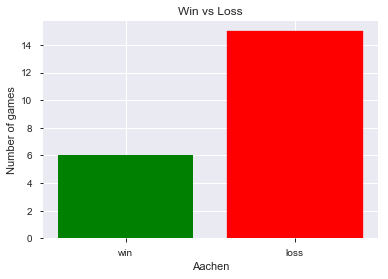

<Figure size 576x144 with 0 Axes>

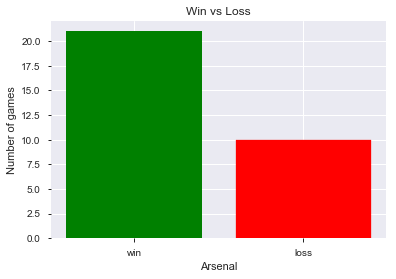

<Figure size 576x144 with 0 Axes>

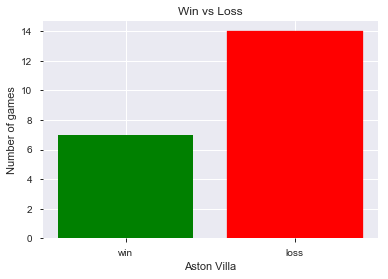

<Figure size 576x144 with 0 Axes>

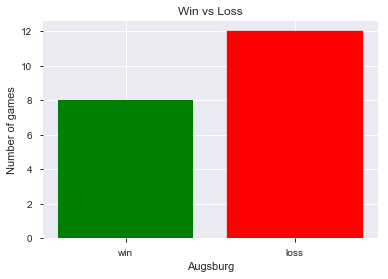

<Figure size 576x144 with 0 Axes>

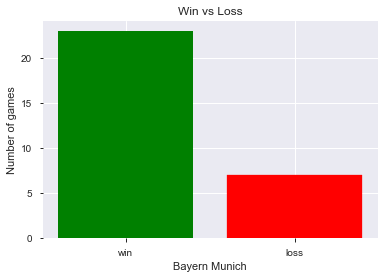

<Figure size 576x144 with 0 Axes>

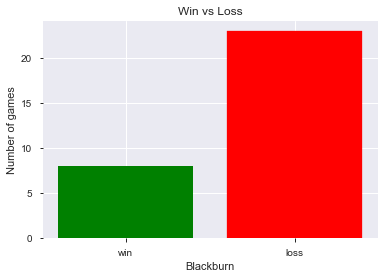

<Figure size 576x144 with 0 Axes>

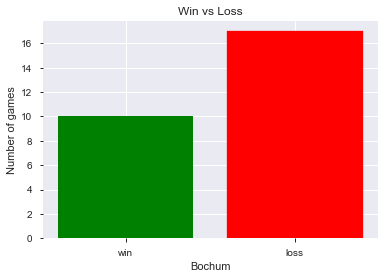

<Figure size 576x144 with 0 Axes>

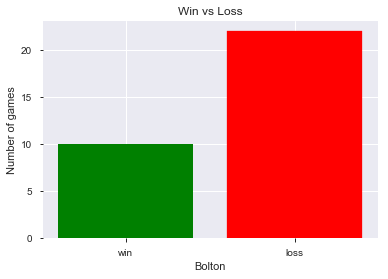

<Figure size 576x144 with 0 Axes>

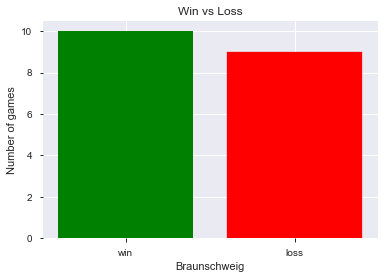

<Figure size 576x144 with 0 Axes>

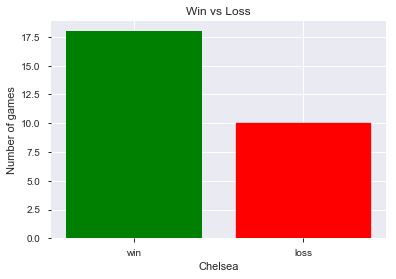

<Figure size 576x144 with 0 Axes>

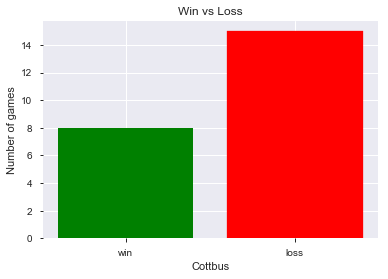

<Figure size 576x144 with 0 Axes>

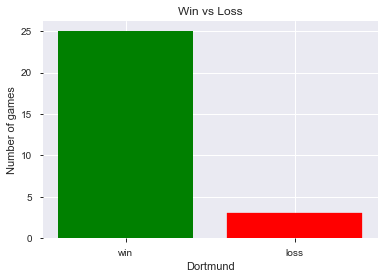

<Figure size 576x144 with 0 Axes>

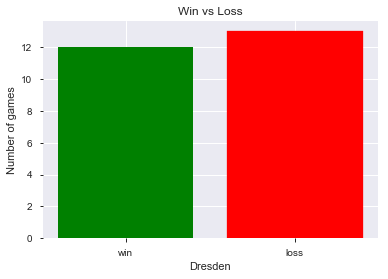

<Figure size 576x144 with 0 Axes>

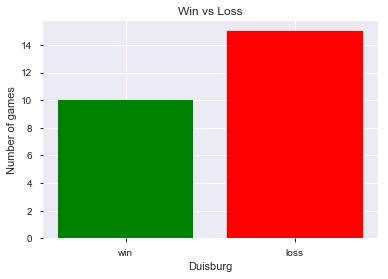

<Figure size 576x144 with 0 Axes>

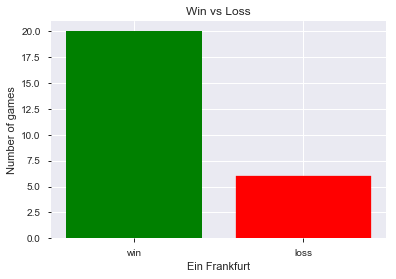

<Figure size 576x144 with 0 Axes>

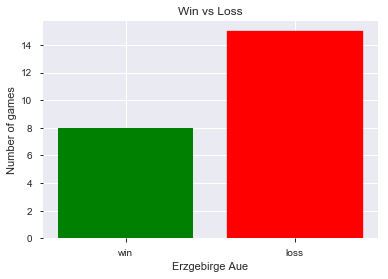

<Figure size 576x144 with 0 Axes>

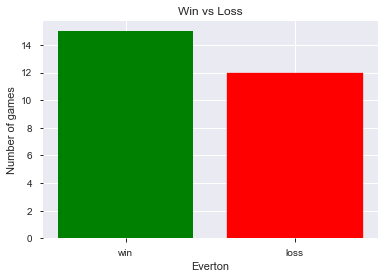

<Figure size 576x144 with 0 Axes>

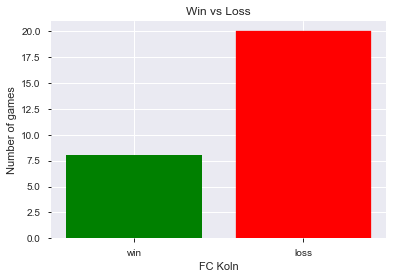

<Figure size 576x144 with 0 Axes>

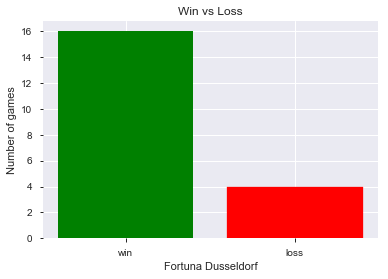

<Figure size 576x144 with 0 Axes>

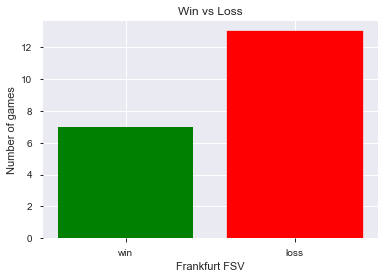

<Figure size 576x144 with 0 Axes>

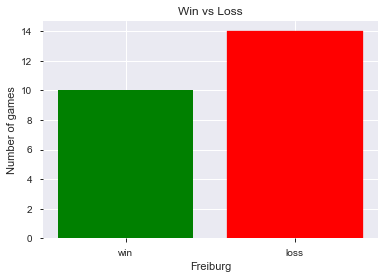

<Figure size 576x144 with 0 Axes>

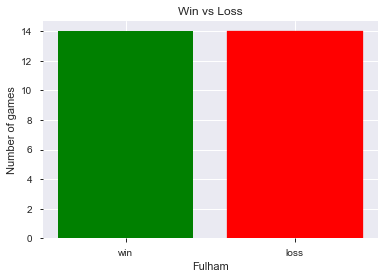

<Figure size 576x144 with 0 Axes>

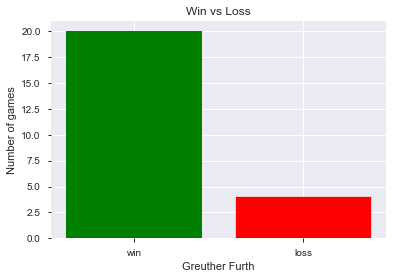

<Figure size 576x144 with 0 Axes>

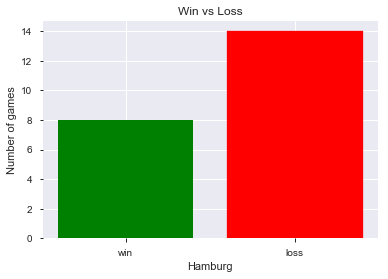

<Figure size 576x144 with 0 Axes>

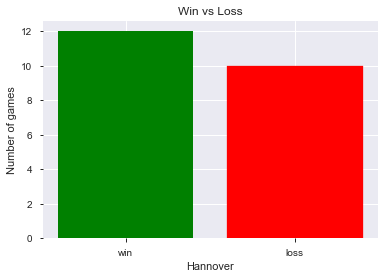

<Figure size 576x144 with 0 Axes>

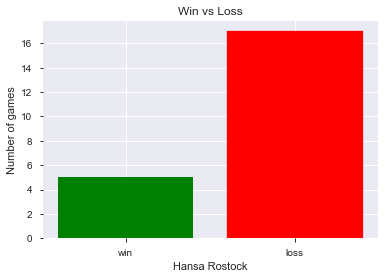

<Figure size 576x144 with 0 Axes>

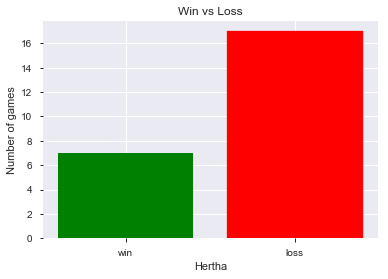

<Figure size 576x144 with 0 Axes>

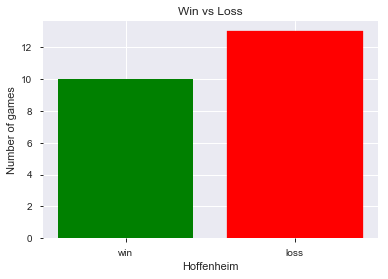

<Figure size 576x144 with 0 Axes>

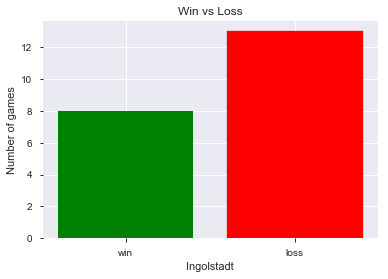

<Figure size 576x144 with 0 Axes>

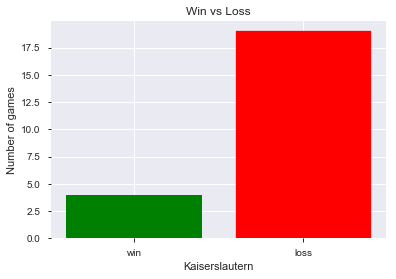

<Figure size 576x144 with 0 Axes>

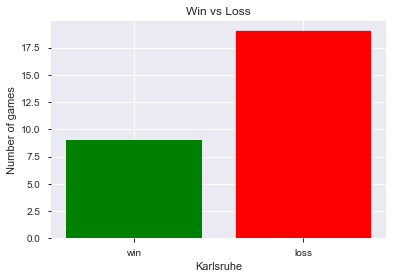

<Figure size 576x144 with 0 Axes>

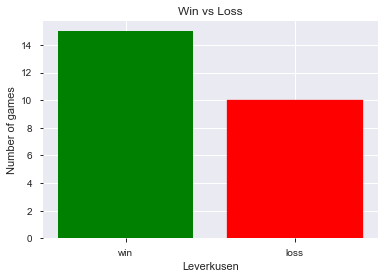

<Figure size 576x144 with 0 Axes>

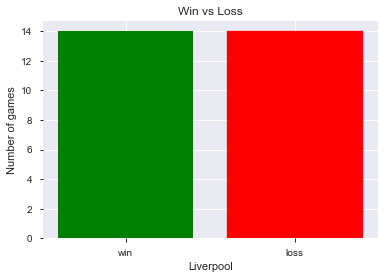

<Figure size 576x144 with 0 Axes>

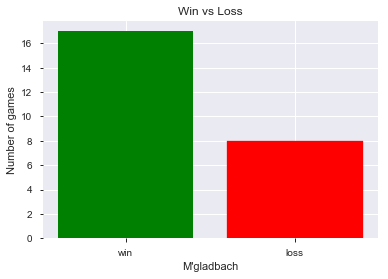

<Figure size 576x144 with 0 Axes>

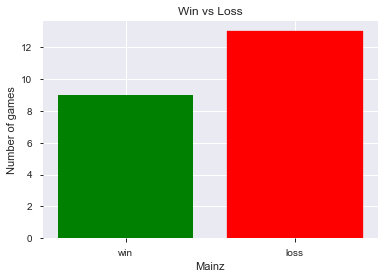

<Figure size 576x144 with 0 Axes>

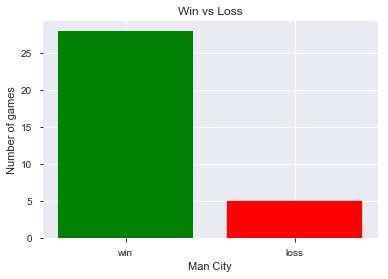

<Figure size 576x144 with 0 Axes>

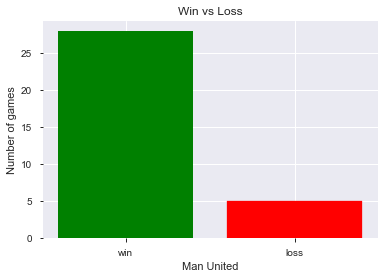

<Figure size 576x144 with 0 Axes>

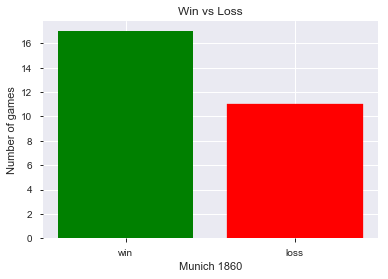

<Figure size 576x144 with 0 Axes>

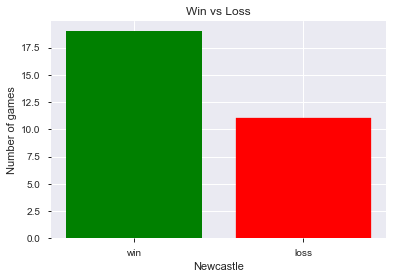

<Figure size 576x144 with 0 Axes>

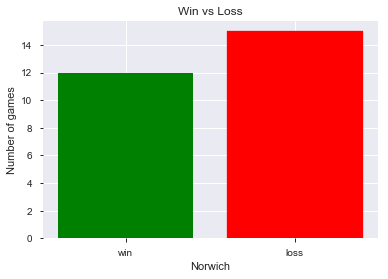

<Figure size 576x144 with 0 Axes>

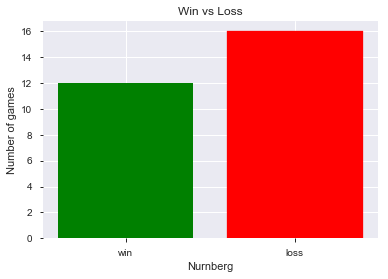

<Figure size 576x144 with 0 Axes>

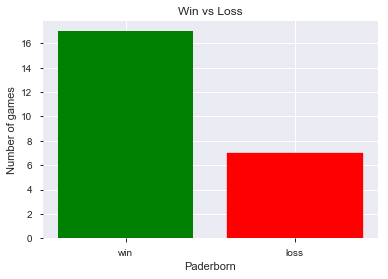

<Figure size 576x144 with 0 Axes>

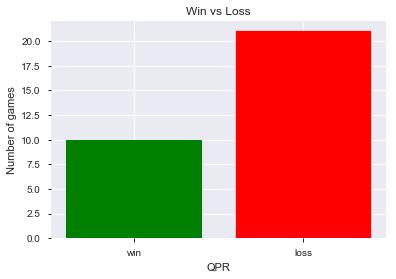

<Figure size 576x144 with 0 Axes>

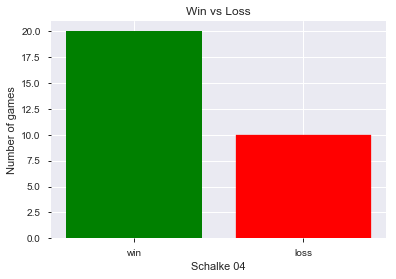

<Figure size 576x144 with 0 Axes>

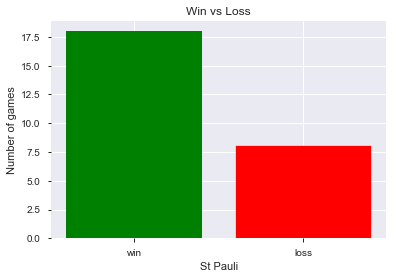

<Figure size 576x144 with 0 Axes>

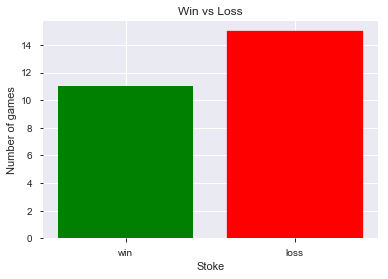

<Figure size 576x144 with 0 Axes>

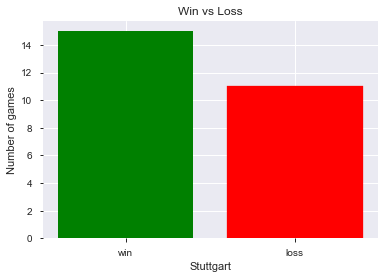

<Figure size 576x144 with 0 Axes>

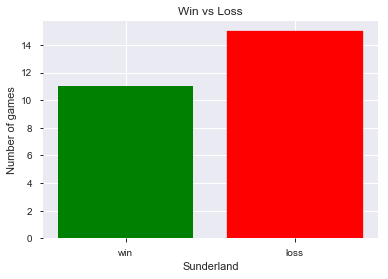

<Figure size 576x144 with 0 Axes>

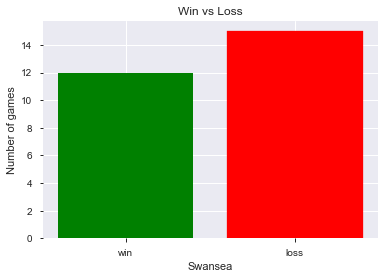

<Figure size 576x144 with 0 Axes>

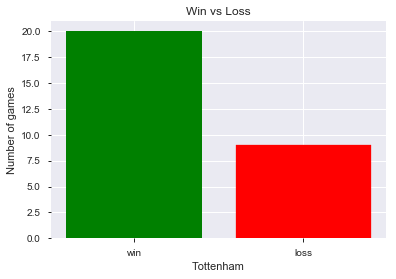

<Figure size 576x144 with 0 Axes>

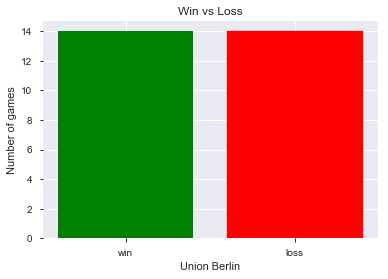

<Figure size 576x144 with 0 Axes>

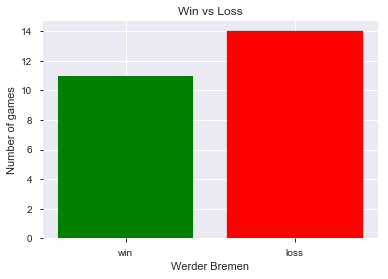

<Figure size 576x144 with 0 Axes>

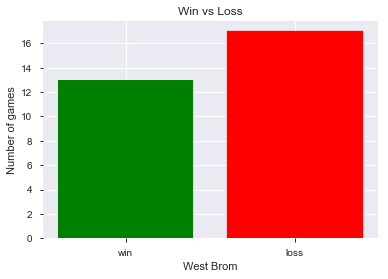

<Figure size 576x144 with 0 Axes>

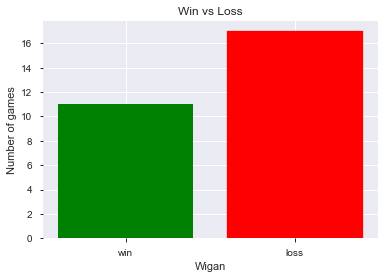

<Figure size 576x144 with 0 Axes>

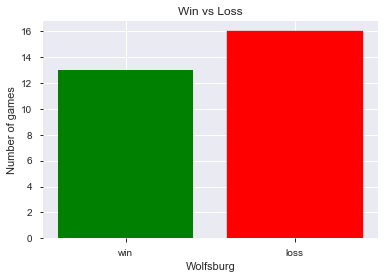

<Figure size 576x144 with 0 Axes>

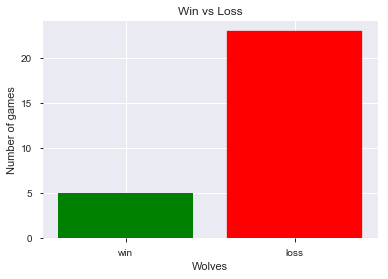

In [115]:

for index, row in df_final.iterrows():
    plt.figure(figsize=(8,2))
    fig, ax1 = plt.subplots()
    bar_list = ax1.bar(x = ['win','loss'],height=[row['Wins'],row['Losses']],color='g')
    bar_list[1].set_color('r')
    ax1.set_xlabel( row['TeamName'] )
    ax1.set_ylabel( 'Number of games' )
    ax1.set_title( "Win vs Loss" )
    plt.show()
#     ax1.set_ylim(.[30, 50] )

In [33]:
game_dates = pd.DataFrame(c.execute(""" SELECT DISTINCT(Date)
FROM Matches
WHERE Season = 2011

""").fetchall())
type(game_dates)

pandas.core.frame.DataFrame

In [ ]:
'''
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
im = Image.open(buf)
buf.close()
'''

In [35]:
#Note: this cell won't return a valid response unless you specify your api key
api_key ='6fdc7f29110982cccf792ed57cd127e7'
url = 'https://api.darksky.net/forecast/6fdc7f29110982cccf792ed57cd127e7/52.52,14.405?exclude=currently,minutely,hourly,alerts,flags'

response = requests.get(url)
#response

In [37]:
forcast_date = []
for date in game_dates[0]:
    url = 'https://api.darksky.net/forecast/6fdc7f29110982cccf792ed57cd127e7/52.52,14.405,'+date+'T00:00:00?exclude=currently,minutely,hourly,alerts,flags'
    resp = requests.get(url)
    forcast_date.append(resp.json()['daily']['data'][0]['icon'])
    

In [39]:
forcast_date

list

In [45]:
game_dates['forecast'] = pd.Series(forcast_date)
game_dates.head()

,0,forcast,forcaste,forecast
0,2012-03-31,cloudy,cloudy,cloudy
1,2011-12-11,clear-day,clear-day,clear-day
2,2011-08-13,clear-day,clear-day,clear-day
3,2011-11-27,clear-day,clear-day,clear-day
4,2012-02-18,cloudy,cloudy,cloudy


In [47]:
game_dates.drop(['forcaste','forecast'], axis=1, inplace=True)

In [48]:
game_dates.columns = ['Date', 'forecast']

In [49]:
game_dates.head()

,Date,forecast
0,2012-03-31,cloudy
1,2011-12-11,clear-day
2,2011-08-13,clear-day
3,2011-11-27,clear-day
4,2012-02-18,cloudy


In [52]:
df_matches = df_matches.merge(game_dates, how='left', on='Date')
df_matches.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,forecast
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,cloudy
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,clear-day
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,clear-day
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,clear-day
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,cloudy


In [58]:
raining_win = []
for team in Team_Names:
    win = 0
    for index, row in df_matches.iterrows():
        if (row['HomeTeam'] == team) and (row['FTR'] == 'H') and (row['forecast'] == 'rain'):
            win += 1
        elif (row['AwayTeam'] == team) and (row['FTR'] == 'A') and (row['forecast'] == 'rain'):
            win += 1
    raining_win.append(win)
    

In [63]:
row['forecast']

'partly-cloudy-day'

In [36]:
SEARCH_LIMIT = 10

url = 'https://api.darksky.net/forecast/6fdc7f29110982cccf792ed57cd127e7/52.52,14.405'

headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }


response = requests.get(url, headers=headers)
print(response)
print(type(response.text))
print(response.text[:1000])

<Response [200]>
<class 'str'>
{"latitude":52.52,"longitude":14.405,"timezone":"Europe/Berlin","currently":{"time":1561943068,"summary":"Mostly Cloudy","icon":"partly-cloudy-night","nearestStormDistance":0,"precipIntensity":0.012,"precipProbability":0.12,"precipType":"rain","temperature":69.17,"apparentTemperature":69.17,"dewPoint":52.56,"humidity":0.55,"pressure":1013.17,"windSpeed":7.35,"windGust":8.63,"windBearing":322,"cloudCover":0.79,"uvIndex":0,"visibility":10,"ozone":312.2},"hourly":{"summary":"Possible light rain tomorrow morning.","icon":"rain","data":[{"time":1561942800,"summary":"Mostly Cloudy","icon":"partly-cloudy-night","precipIntensity":0.012,"precipProbability":0.12,"precipType":"rain","temperature":69.39,"apparentTemperature":69.39,"dewPoint":52.62,"humidity":0.55,"pressure":1013.16,"windSpeed":7.4,"windGust":8.74,"windBearing":323,"cloudCover":0.78,"uvIndex":0,"visibility":10,"ozone":312},{"time":1561946400,"summary":"Overcast","icon":"cloudy","precipIntensity":0.016

In [ ]:
response.json().keys()

In [117]:
for key in response.json().keys():
    print(key)
    value = response.json()[key] #Use standard dictionary formatting
    print(type(value)) #What type is it?
    print('\n\n') #Separate out data

latitude
<class 'float'>



longitude
<class 'float'>



timezone
<class 'str'>



currently
<class 'dict'>



hourly
<class 'dict'>



daily
<class 'dict'>



flags
<class 'dict'>



offset
<class 'int'>





In [7]:
field_dict = {}

for tab_name in df_master.name:
    sql_2 = """

    SELECT * bFROM {}

    """.format(tab_name)
    c.execute(sql_2)
    field_dict.update({tab_name: [x[0] for x in c.description]})

    
print("table names: {}".format(list(field_dict.keys())))
print("\n")

for tab_name in field_dict.keys():
    print("""columns in table "{}": {}\n""".format(tab_name, field_dict[tab_name]))


table names: ['sqlite_sequence', 'Matches', 'Teams_in_Matches', 'Teams', 'Unique_Teams']


columns in table "sqlite_sequence": ['name', 'seq']

columns in table "Matches": ['Match_ID', 'Div', 'Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']

columns in table "Teams_in_Matches": ['Match_ID', 'Unique_Team_ID']

columns in table "Teams": ['Season', 'TeamName', 'KaderHome', 'AvgAgeHome', 'ForeignPlayersHome', 'OverallMarketValueHome', 'AvgMarketValueHome', 'StadiumCapacity']

columns in table "Unique_Teams": ['TeamName', 'Unique_Team_ID']

